# Lectures - Symbolic QM with SymPsi

Author: J. R. Johansson (robert@riken.jp), [http://jrjohansson.github.io](http://jrjohansson.github.io).

This notebook is part of a series of IPython notebooks on symbolic quantum mechanics computations using 
[SymPy](http://sympy.org) and [SymPsi](http://www.github.com/jrjohansson/sympsi). 
- SymPsi is an experimental fork and extension of the [`sympy.physics.quantum`](http://docs.sympy.org/dev/modules/physics/quantum/) module in SymPy. 
  - Disclaimer: The SymPsi module is still under active development and may change in behavior without notice, and the intention is to move some of its features to [`sympy.physics.quantum`](http://docs.sympy.org/dev/modules/physics/quantum/) when they matured and have been tested. However, these notebooks will be kept up-to-date the latest versions of SymPy and SymPsi.
- The latest version of this notebook is available at [http://github.com/jrjohansson/sympy-quantum-notebooks](http://github.com/jrjohansson/sympy-quantum-notebooks).

These notebooks are to demonstrate how analytical calculations that are often necessary when working with these quantum mechanical systems can be carried out symbolically. 

 * [Two-level systems](lecture-sympsi-two-level-system.ipynb)
   * Eigenbasis
 * [Resonators and cavities](lecture-sympsi-resonator.ipynb)
   * Classical driving fields
   * Rotating frames and the rotating-wave approximation
   * Optical parametric oscillator
 * [Atom and cavity](lecture-sympsi-atom-cavity.ipynb)
   * The Jaynes-Cumming model
   * Dispersive regime
 * [Optomechanics](lecture-sympsi-optomechanics.ipynb)
   * Linear regime
     * Red sideband
     * Blue sideband
   * Kerr effect and photon blockade
 * Input/Output theory
   * Quantum Langevin equation
   * One-sided cavity
 * Master equations
   * Adjoint master equation
 * [Semiclassical equations of motion](lecture-sympsi-semiclassical-eqm.ipynb)
 * Composite systems

# Lecture 2 - Symbolic quantum mechanics using SymPsi - Two-level systems

## Setup modules

In [ ]:
from sympy import *
init_printing()

In [ ]:
from sympsi import *
from sympsi.pauli import *

## Introduction: Hamiltonian and Pauli matrices

One of the simplest possible quantum system is the two-level system, such as a spin-$1/2$, or an atom or artificial-atom (nano-device) with (effectively) only two quantum states. 

The Hamiltonian for a two-level quantum system is conveniently written in terms of the [Pauli matrices](http://en.wikipedia.org/wiki/Pauli_matrices) $\sigma_x$, $\sigma_y$ and $\sigma_z$, and their annihilation and creation operators $\sigma_-$ and $\sigma_+$. In terms of these operators we can write the Hamiltonian on the form:

$$
H = -\frac{1}{2}\Delta\sigma_x - \frac{1}{2}\epsilon\sigma_z 
$$

where $\epsilon$ is the bare energy splitting and $\Delta$ is the tunneling rate between the two states of the two-level system.

In SymPy we can represent this Hamiltonian as:

In [ ]:
theta, t = symbols("theta, t")
eps, Delta, Omega = symbols("epsilon, Delta, Omega", positive=True)
Hsym = symbols("H")

In [ ]:
sx, sy, sz = SigmaX(), SigmaY(), SigmaZ()

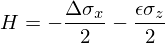

In [ ]:
H = -eps/2 * sz - Delta/2 * sx

Eq(Hsym, H)

## Instantaneous eigenbasis

Is often convenient to perform basis transformation that simplifies the Hamiltonian. For example, we can transform the Hamiltonian to the eigenbasis (where the Hamiltonian is diagonal, that is only containing a $\sigma_z$ term) by applying the unitary tranformation:

In [ ]:
U = exp(I * theta/2 * sy); U

This unitary tranformation transforms the operators in the Hamiltonian according to these well-known relations:

In [ ]:
hamiltonian_transformation(U, sx)

In [ ]:
hamiltonian_transformation(U, sz)

so the Hamiltonian after this transformation takes the form 

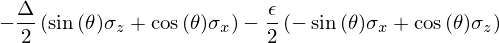

In [ ]:
H1 = hamiltonian_transformation(U, H)

H1

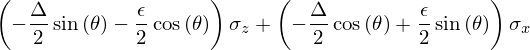

In [ ]:
H2 = collect(H1.expand(), (sx, sz))

H2

In the eigenbasis we require the coefficient of $\sigma_x$ to be zero, so we have the condition:

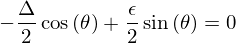

In [ ]:
c, o = split_coeff_operator(H2.args[0])

Eq(c, 0)

with the solution

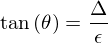

In [ ]:
Eq(tan(theta), Delta/eps)

Substituting this into the Hamiltonian results in 

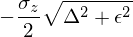

In [ ]:
H3 = simplify(H2.subs(theta, atan(Delta/eps)))

H3

Now introduce $\Omega = \sqrt{\Delta^2 + \epsilon^2}$, which is the eigenenergies of the two-level system:

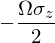

In [ ]:
H3.subs(Delta, sqrt(Omega ** 2 - eps ** 2))

In summary, to reach this basis, we have transformed $\sigma_x$ and $\sigma_z$ as:

In [ ]:
hamiltonian_transformation(U, sx)

In [ ]:
hamiltonian_transformation(U, sz)

and chosen $\theta = \arctan(\Delta/\epsilon)$.

## Versions

In [ ]:
%reload_ext version_information

%version_information sympy, sympsi

Software versions
Python 3.4.1 (default, Sep 20 2014, 19:44:17) [GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
IPython 2.3.0
OS Darwin 13.4.0 x86_64 i386 64bit
sympy 0.7.5-git
sympsi 0.1.0.dev-0c6e514
Thu Oct 09 15:23:41 2014 JST

# Lecture 3 - Symbolic quantum mechanics using SymPsi - Resonators and cavities

## Setup modules

In [ ]:
from sympy import *
init_printing()

In [ ]:
from sympsi import *
from sympsi.boson import *
from sympsi.operatorordering import *

## Introduction

In this notebook we will work with cavities and resonators. A single mode of a resonator can be modelled with a quantum harmonic oscillator. Here we look at the effect of classical driving fields, transformation to different rotating frames, and various types of coupling between different modes in a resonator.

## Quantum Harmonic Oscillator

First we consider the Hamiltonian for a single harmonic oscillator, which describes a single mode of for example a cavity or a waveguide resonator:

$$
H = \hbar \omega_r a^\dagger a
$$

To represent this Hamiltonian in sympy we create a symbol `omega_r` and an instance of the class `BosonOp`:

In [ ]:
omega_r = symbols("omega_r", positive=True)
Hsym = symbols("H")
a = BosonOp("a")

In [ ]:
H0 = omega_r * Dagger(a) * a

Eq(Hsym, H0)

### Classical drive signal

A classical driving field of frequency $\omega_d$ and amplitude $A$ and phase $\phi_0$ can be modelled by including an additional term in the Hamiltonian:

$$
H = \hbar \omega_r a^\dagger a + A \cos(\omega_dt  + \phi_0) (a + a^\dagger)
$$

where we have assumed that the driving field couples to the quadrature of the resonator $a + a^\dagger$, which is the canonical case. It is convenient to rewrite the $\cos$ factor

$$
H = \hbar \omega_r a^\dagger a + (Ae^{-i\omega_dt}+ A^*e^{i\omega_dt})(a + a^\dagger)
$$

where we have redefined $A \rightarrow Ae^{-i\phi_0}$. In Sympy we can represent this Hamiltonian as:

In [ ]:
omega_d, t = symbols("omega_d, t")
A = symbols("A")

In [ ]:
Hdrive = (A * exp(-I * omega_d * t) + conjugate(A) * exp(I * omega_d * t)) * (a + Dagger(a))

Hdrive

In [ ]:
H = H0 + Hdrive

Eq(Hsym, H)

When working with Hamiltonians like this one, one common operation is to move to different rotating frames (by performing unitary transformations) where the Hamiltonian takes a simplier form.

Here we want to transform this Hamiltonian to a rotating frame in which the drive term (and all other terms) are no longer explicitly depening on time `t`. We can accomplish this by performing the unitary transformation 

$$
U = \exp(i\omega_d a^\dagger a t)
$$

In [ ]:
U = exp(I * omega_d * t * Dagger(a) * a)

U

When doing a unitary basis transformation, the Hamiltonian is transformed as

$$
H \rightarrow UHU^\dagger -i U \frac{d}{dt}U^\dagger
$$

and we can carry out this transformation using the function `hamiltonian_transformation`:

In [ ]:
H2 = hamiltonian_transformation(U, H.expand())

H2

Now let's introduce the detuning $\Delta = \omega_r - \omega_d$:

In [ ]:
Delta = symbols("Delta", positive=True)

In [ ]:
H3 = collect(H2, Dagger(a) * a).subs(omega_r - omega_d, Delta)

H3

### Rotating-wave approximation (RWA)

Now we invoke the rotating-wave approximation, under which we assume that $\omega_d$ is much larger than $\Delta$, so that the we can neglect the two fast rotating terms which contains factors $\exp(\pm 2i \omega_d t)$:

In [ ]:
H3 = drop_terms_containing(H3, [exp( 2 * I * omega_d * t),
                                exp(-2 * I * omega_d * t)])

Eq(Hsym, H3)

This is a time-independent hamiltonian describing the resonator in a rotating frame, where fast rotating terms have been dropped. We can no apply a displacement transformation by applying the unitary transformation:

In [ ]:
alpha = symbols("alpha")
H = Dagger(a) * alpha - conjugate(alpha) * a
U = exp(H)

U

In [ ]:
H4 = hamiltonian_transformation(U, H3)

H4 = collect(H4.expand(), [Dagger(a)*a, a, Dagger(a)])

H4

If we choose $\alpha = A/\Delta$ and drop c-numbers from the hamiltonian, we obtain a particularly simple form:

In [ ]:
H5 = H4.subs(alpha, A/Delta)

H5 = drop_c_number_terms(H5)

H5

So a driven harmonic oscillator can be described by the hamiltonian of an undriven harmonic oscillator in a displaced frame.

## Optical parametric oscillator

An optical parametric oscillator (OPO) is a two-mode system with a particular nonlinear interaction. The Hamiltonian of the OPO is

$$
H = \omega_r a^\dagger a + \omega_p b^\dagger b + (\kappa {a^\dagger}^2 b + \kappa^* a^2 b^\dagger) + (A e^{i\omega_pt} + A^* e^{-i\omega_pt})(b + b^\dagger)
$$

where the operators of the two modes are$a$ and $b$, and the nonlinear interaction strength is $\kappa$, and where we have also included a classical drive field applied to mode $b$.

To model this system in SymPy we create two instances of `BosonOp`, one for each mode, and construct the Hamiltonian:

In [ ]:
a, b = BosonOp("a"), BosonOp("b")

In [ ]:
kappa, omega_p, omega_a, omega_b, t = symbols("kappa, omega_p, omega_a, omega_b, t")
Delta_a, Delta_b = symbols("Delta_a, Delta_b", positive=True)

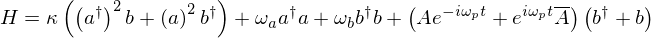

In [ ]:
Hdrive = (A * exp(-I * omega_p * t) + conjugate(A) * exp(I * omega_p * t)) * (b + Dagger(b))
H1 = omega_a * Dagger(a) * a + omega_b * Dagger(b) * b  + kappa * (a ** 2 * Dagger(b) + Dagger(a) ** 2 * b) + Hdrive

Eq(Hsym, H1)

We first move to a frame rotating with frequency $\omega_p$ with respect to mode $b$:

In [ ]:
U = exp(I * omega_p * t * Dagger(b) * b)

U

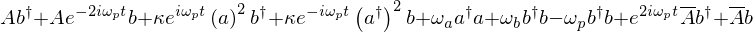

In [ ]:
H2 = hamiltonian_transformation(U, H1.expand(), independent=True)

H2

and we can perform the rotating wave approximation and drop the fast rotating terms $\exp{\left(\pm i \omega_p t\right)}$:

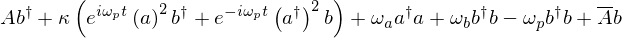

In [ ]:
H3 = drop_terms_containing(H2, [exp(2 * I * omega_p * t),
                                exp(-2 * I * omega_p * t)])

H3 = collect(H3, kappa)

H3

Introduce a new variable for the detuning $\Delta_b = \omega_b - \omega_p$:

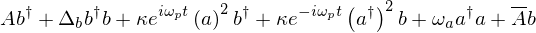

In [ ]:
H4 = H3.subs(omega_b, Delta_b + omega_p).expand()

H4

Next we want to displace the mode $b$ so that the drive terms are eliminated:

In [ ]:
beta = symbols("beta")
H = Dagger(b) * beta - conjugate(beta) * b
U = exp(H)

U

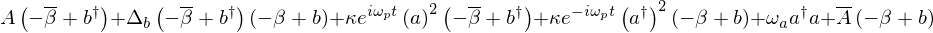

In [ ]:
H5 = hamiltonian_transformation(U, H4.expand(), independent=True)

H5

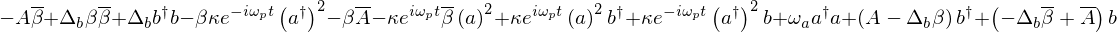

In [ ]:
H5 = collect(H5.expand(), [Dagger(a) * a, Dagger(b) * b, Dagger(a) ** 2 * b, a ** 2 * Dagger(b), b, Dagger(b)])

H5

The choice $\beta = A/\Delta_b$ eliminates the drive terms. After dropping c numbers we have:

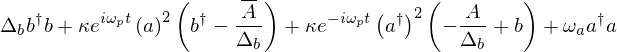

In [ ]:
H6 = H5.subs(beta, A/Delta_b)

H6 = drop_c_number_terms(H6)

H6 = collect(H6, [exp( I * omega_p * t) * kappa * a ** 2,
                  exp(-I * omega_p * t) * kappa * Dagger(a) ** 2])

H6

If we now assume that the dynamics of the mode $b$ is dominated by the classical drive field, we can neglect the $b$ operators in the hamiltonian (in this displaced frame, which describes deviations from the dynamics induced by the classical driving field):

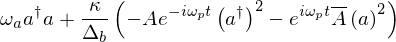

In [ ]:
H7 = drop_terms_containing(H6.expand(), [b, Dagger(b)])

H7 = collect(H7, kappa / Delta_b)

H7

To simpify the notation we redefine $- \kappa A / \Delta_b \rightarrow \kappa$, and assume that $A$ is real:

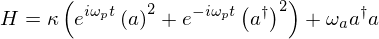

In [ ]:
H = omega_a * Dagger(a) * a  + kappa * (a ** 2 * exp(I * omega_p * t) + Dagger(a) ** 2 * exp(-I * omega_p * t))

Eq(Hsym, H)

To eliminate the time-dependence in the interaction term we move to a rotating frame using the unitary transformation:

In [ ]:
U = exp(I * omega_d * t * Dagger(a) * a)

U

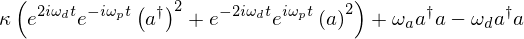

In [ ]:
H2 = hamiltonian_transformation(U, H)

H2

Now consider the case $\omega_p = 2 \omega_d$:

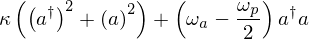

In [ ]:
H3 = H2.subs(omega_d, omega_p/2)

H3 = collect(H3, Dagger(a) * a)

H3

Introduce $\Delta_a = \omega_a - \omega_p / 2$:

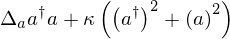

In [ ]:
H4 = H3.subs(omega_a, Delta_a + omega_p/2)

H4

We can diagonalize this Hamiltonian by introducing the squeezing transformation:

In [ ]:
chi = symbols("chi")

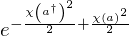

In [ ]:
U = exp(chi/2 * a **2 - chi/2 * Dagger(a) ** 2)

U

which tranforms the operators $a$ and $a^\dagger$ according to the well-known relations:

In [ ]:
hamiltonian_transformation(U, a)

In [ ]:
hamiltonian_transformation(U, Dagger(a))

and in this frame the Hamiltonian takes the form:

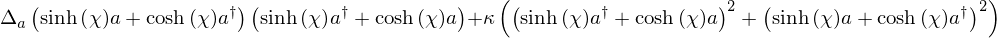

In [ ]:
H5 = hamiltonian_transformation(U, H4)

H5

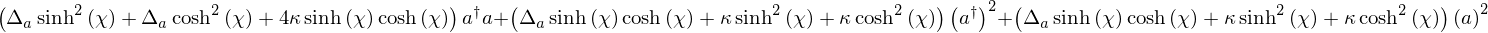

In [ ]:
H6 = normal_ordered_form(H5.expand(), independent=True)

H6 = drop_c_number_terms(H6)

H6 = collect(H6, [Dagger(a) * a, Dagger(a)**2, a**2])

H6

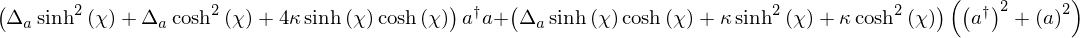

In [ ]:
H7 = collect(H6, H6.args[1].args[0])

H7

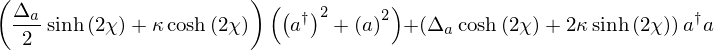

In [ ]:
# Trick to simplify the coefficients for the quantum operators
H8 = Add(*(simplify(arg.args[0]) * Mul(*(arg.args[1:])) for arg in H7.args))

H8

Now if we choose $\chi$ such that the coefficient of $a^2 + {a^\dagger}^2$ is zero:

In [ ]:
chi_eq = H8.args[0].args[0]

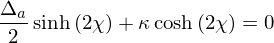

In [ ]:
Eq(chi_eq, 0)

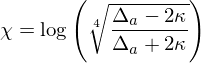

In [ ]:
chi_sol = simplify(solve(chi_eq, chi)[3])

Eq(chi, chi_sol)

we obtain a diagonal Hamiltonian:

In [ ]:
H9 = H8.subs(chi_eq.args[0], -chi_eq.args[1])

H9

with frequency:

In [ ]:
Eq(Symbol("omega"), H9.args[0])

### Versions

In [ ]:
%reload_ext version_information

%version_information sympy, sympsi

Software versions
Python 3.4.1 (default, Sep 20 2014, 19:44:17) [GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
IPython 2.3.0
OS Darwin 13.4.0 x86_64 i386 64bit
sympy 0.7.5-git
sympsi 0.1.0.dev-0c6e514
Thu Oct 09 16:01:18 2014 JST

# Lecture 4 - Symbolic quantum mechanics using SymPsi - Atom and cavity

<style>
p {
    font-family: "Liberation Serif", serif;
    font-size: 12pt;
}
</style>

## Setup modules

In [ ]:
from sympy import *
init_printing()

In [ ]:
from sympsi import *
from sympsi.boson import *
from sympsi.pauli import *

## The Jaynes-Cummings model

The [Jaynes-Cummings model](http://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model) is one of the most elementary quantum mechanical models light-matter interaction. It describes a single two-level atom that interacts with a single harmonic-oscillator mode of a electromagnetic cavity.

The Hamiltonian for a two-level system in its eigenbasis (see [Two-level systems](lecture-sympy-quantum-two-level-system.ipynb)) can be written as

$$
H = \frac{1}{2}\Omega \sigma_z
$$

and the Hamiltonian of a quantum harmonic oscillator (see [Resonators and cavities](lecture-sympy-quantum-resonators.ipynb)) is

$$
H = \hbar\omega_r (a^\dagger a + 1/2)
$$

The atom interacts with the electromagnetic field produced by the cavity mode $a + a^\dagger$ through its dipole moment. The dipole-transition operators is $\sigma_x$ (which cause a transition from the two dipole states of the atom). The combined atom-cavity Hamiltonian can therefore be written in the form

$$
H = 
\hbar\omega_r (a^\dagger a + 1/2)
+ \frac{1}{2}\hbar\Omega\sigma_z 
+
\hbar
g\sigma_x(a + a^\dagger)
$$


To obtain the Jaynes-Cumming Hamiltonian 

$$
H = 
\hbar\omega_r (a^\dagger a + 1/2)
%-\frac{1}{2}\Delta\sigma_x 
+ \frac{1}{2}\hbar\Omega\sigma_z 
+
\hbar
g(\sigma_+ a + \sigma_- a^\dagger)
$$

we also need to perform a rotating-wave approximation which simplifies the interaction part of the Hamiltonian. In the following we will begin with looking at how these two Hamiltonians are related.

To represent the atom-cavity Hamiltonian in SymPy we creates an instances of the operator classes `BosonOp` and `SigmaX`, `SigmaY`, and `SigmaZ`, and use these to construct the Hamiltonian (we work in units where $\hbar = 1$).

In [ ]:
omega_r, Omega, g, Delta, t, x, Hsym = symbols("omega_r, Omega, g, Delta, t, x, H")

In [ ]:
sx, sy, sz, sm, sp = SigmaX(), SigmaY(), SigmaZ(), SigmaMinus(), SigmaPlus()
a = BosonOp("a")

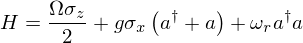

In [ ]:
H = omega_r * Dagger(a) * a + Omega/2 * sz + g * sx * (a + Dagger(a))

Eq(Hsym, H)

To simplify the interaction term we carry out two unitary transformations that corresponds to moving to the interaction picture:

In [ ]:
U = exp(I * omega_r * t * Dagger(a) * a)

U

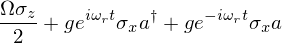

In [ ]:
H2 = hamiltonian_transformation(U, H.expand())

H2

In [ ]:
U = exp(I * Omega * t * sp * sm)

U

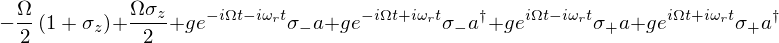

In [ ]:
H3 = hamiltonian_transformation(U, H2.expand())

H3 = H3.subs(sx, sm + sp).expand()

H3 = powsimp(H3)

H3

We introduce the detuning parameter $\Delta = \Omega - \omega_r$ and substitute into this expression

In [ ]:
# trick to simplify exponents
def simplify_exp(e):
    if isinstance(e, exp):
        return exp(simplify(e.exp.expand()))

    if isinstance(e, (Add, Mul)):
        return type(e)(*(simplify_exp(arg) for arg in e.args)) 

    return e

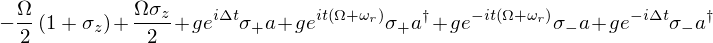

In [ ]:
H4 = simplify_exp(H3).subs(-omega_r + Omega, Delta)

H4

Now, in the rotating-wave approximation we can drop the fast oscillating terms containing the factors $e^{\pm i(\Omega + \omega_r)t}$

In [ ]:
H5 = drop_terms_containing(H4, [exp( I * (Omega + omega_r) * t),
                                exp(-I * (Omega + omega_r) * t)])

H5 = drop_c_number_terms(H5.expand())

Eq(Hsym, H5)

This is the interaction term of in the Jaynes-Cumming model in the interaction picture. If we transform back to the Schrödinger picture we have:

In [ ]:
U = exp(-I * omega_r * t * Dagger(a) * a)
H6 = hamiltonian_transformation(U, H5.expand())

In [ ]:
U = exp(-I * Omega * t * sp * sm)
H7 = hamiltonian_transformation(U, H6.expand())

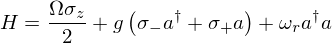

In [ ]:
H8 = simplify_exp(H7).subs(Delta, Omega - omega_r)

H8 = simplify_exp(powsimp(H8)).expand()

H8 = drop_c_number_terms(H8)

H = collect(H8, g)

Eq(Hsym, H)

This is the Jaynes-Cumming model give above, and we have now seen that it is obtained to the dipole interaction Hamiltonian through the rotating wave approximation.

## Dispersive regime

In the dispersive regime, where the two-level system is detuned from the cavity by much more than the interaction strength, $\Delta \gg g$, an effective Hamiltonian can be dervied which describes the Stark shift of the two-level system (which depends on the number of photons in the cavity) and the frequency shift of the cavity (which depend on the state of the two-level system).

This effective Hamiltonian, which is correct up to second order in the small paramter $g/\Delta$, is obtained by performing the unitary transformation

$$
U = e^{\frac{g}{\Delta}(a \sigma_- - a^\dagger \sigma_+)}
$$

In [ ]:
U = exp((x * (a * sp - Dagger(a) * sm)).expand())

U

In [ ]:
#H1 = unitary_transformation(U, H, allinone=True, expansion_search=False, N=3).expand()
#H1 = qsimplify(H1)
#H1

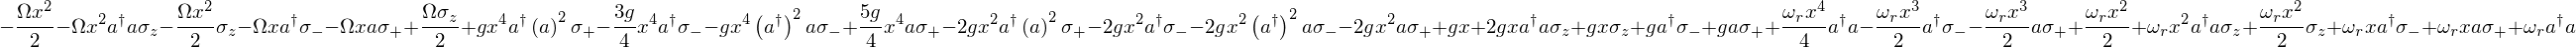

In [ ]:
H1 = hamiltonian_transformation(U, H, expansion_search=False, N=3).expand()

H1 = qsimplify(H1)

H1

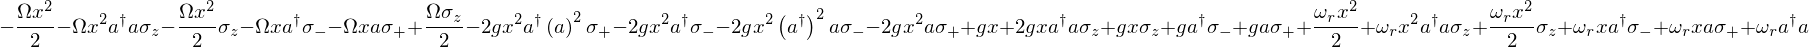

In [ ]:
H2 = drop_terms_containing(H1.expand(), [x**3, x**4])

H2

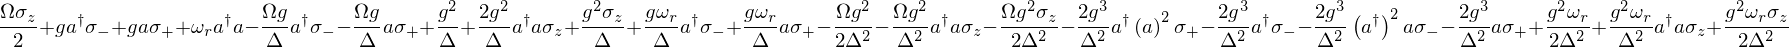

In [ ]:
H3 = H2.subs(x, g/Delta)

H3

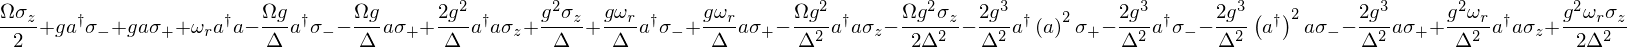

In [ ]:
H4 = drop_c_number_terms(H3)

H4

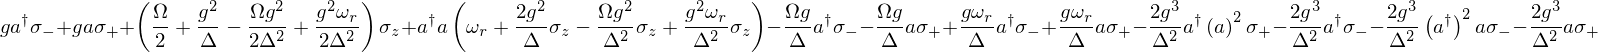

In [ ]:
H5 = collect(H4, [Dagger(a) * a, sz])

H5

Now move to a frame co-rotating with the qubit and oscillator frequencies: 

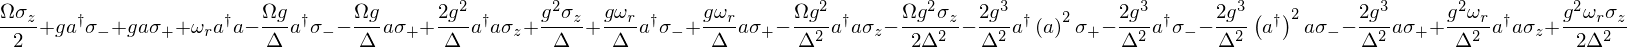

In [ ]:
H5.expand()

In [ ]:
U = exp(I * omega_r * t * Dagger(a) * a)

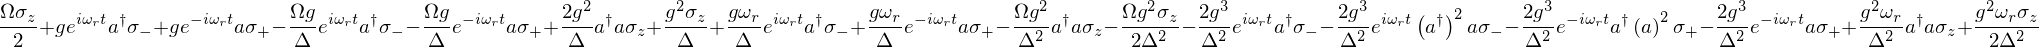

In [ ]:
H6 = hamiltonian_transformation(U, H5.expand()); H6

In [ ]:
U = exp(I * Omega * t * Dagger(sm) * sm)

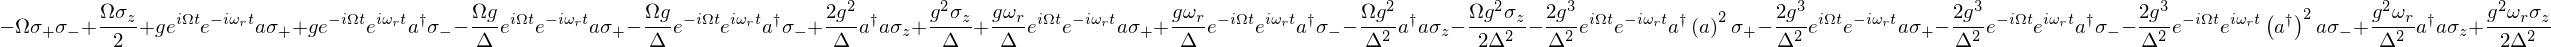

In [ ]:
H7 = hamiltonian_transformation(U, H6.expand()); H7

Now, since we are in the dispersive regime $|\Omega-\omega_r| \gg g$, we can do a rotating-wave approximation and drop all the fast rotating terms in the Hamiltonian above:

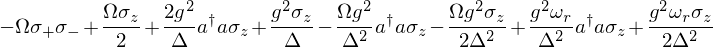

In [ ]:
H8 = drop_terms_containing(H7, [exp(I * omega_r * t), exp(-I * omega_r * t),
                                exp(I * Omega * t), exp(-I * Omega * t)])

H8

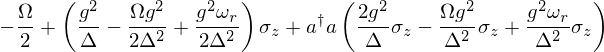

In [ ]:
H9 = qsimplify(H8)

H9 = collect(H9, [Dagger(a) * a, sz])

H9

Now move back to the lab frame:

In [ ]:
U = exp(-I * omega_r * t * Dagger(a) * a)

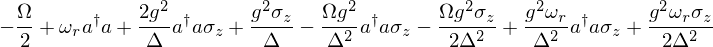

In [ ]:
H10 = hamiltonian_transformation(U, H9.expand()); H10

In [ ]:
U = exp(-I * Omega * t * Dagger(sm) * sm)

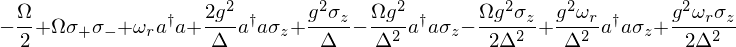

In [ ]:
H11 = hamiltonian_transformation(U, H10.expand()); H11

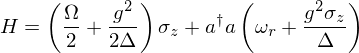

In [ ]:
H12 = qsimplify(H11)

H12 = collect(H12, [Dagger(a) * a, sz])

H12 = H12.subs(omega_r, Omega-Delta).expand().collect([Dagger(a)*a, sz]).subs(Omega-Delta,omega_r)

Eq(Hsym, H12)

This is the Hamiltonian of the Jaynes-Cummings model in the the dispersive regime. It can be interpreted as the resonator having a qubit-state-dependent frequency shift, or alternatively that the qubit is feeling a resonator-photon-number dependent Stark-shift.

## Versions

In [ ]:
%reload_ext version_information

%version_information sympy, sympsi

Software versions
Python 3.4.1 (default, Sep 20 2014, 19:44:17) [GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
IPython 2.1.0
OS Darwin 13.4.0 x86_64 i386 64bit
sympy 0.7.5-git
sympsi 0.1.0.dev-9060485
Thu Oct 09 16:25:51 2014 JST

# Lecture 5 - Symbolic quantum mechanics using SymPsi - Optomechanics

<style>
p {
    font-family: "Liberation Serif", serif;
    font-size: 12pt;
}
</style>

## Setup modules

In [ ]:
from sympy import *
init_printing()

In [ ]:
from sympsi import *
from sympsi.boson import *
from sympsi.operatorordering import *

## Optomechanical system

Consider the standard Hamiltonian for an optomechanical system, including a classical driving signal on the optical mode:

$$
H = \hbar\omega_a a^\dagger a + \hbar \omega_b b^\dagger b - \hbar g a^\dagger a (b + b^\dagger) + (A e^{-i\omega_d t} + A^* e^{i\omega_d t})(a + a^\dagger)
$$



In [ ]:
omega_a, omega_b, g, A, Delta, t = symbols("omega_a, omega_b, g, A, Delta, t", positive=True)
Hsym, omega_d = symbols("H, omega_d")

In [ ]:
a, b = BosonOp("a"), BosonOp("b")

In [ ]:
H0 = omega_a * Dagger(a) * a + omega_b * Dagger(b) * b - g * Dagger(a) * a * (b + Dagger(b))

Hdrive = (A * exp(-I * omega_d * t) + conjugate(A) * exp(I * omega_d * t)) * (a + Dagger(a))

H = H0 + Hdrive

Eq(Hsym, H)

### Linearized interaction

First we apply the unitary transformation $U = e^{i \omega_d a^\dagger a t}$:

In [ ]:
U = exp(I * Dagger(a) * a * omega_d * t)

U

In [ ]:
H1 = hamiltonian_transformation(U, H, independent=True)

H1

We can now perform a rotating-wave approximation (RWA) by eliminating all terms that rotate with frequencies $2\omega_d$:

In [ ]:
H2 = drop_terms_containing(H1.expand(), [exp(-2*I*omega_d*t), exp(2*I*omega_d*t)])

Eq(Symbol("H_{rwa}"), H2)

Introduce the detuning $\Delta = \omega_a - \omega_d$:

In [ ]:
H3 = H2.subs(omega_a, Delta + omega_d).expand()

H3

To eliminate the coherent part of the state of the cavity mode we apply the unitary displacement operator $U = e^{\alpha a^\dagger - \alpha^*a}$:

In [ ]:
alpha = symbols("alpha")

In [ ]:
UH = Dagger(a) * alpha - conjugate(alpha) * a
U = exp(UH)

U

In [ ]:
H4 = hamiltonian_transformation(U, H3, independent=True)

H4

Now want to cancel out the drivng terms so we set $A - \Delta \alpha = 0$, i.e. $\alpha = A/\Delta$:

In [ ]:
H5 = H4.expand().subs({A: alpha * Delta, conjugate(alpha): alpha}) 

H5 = collect(H5, [g * Dagger(a) * a, - alpha * g])

H5

Drop C-numbers from the Hamiltonian:

In [ ]:
H6 = drop_c_number_terms(H5)

H6

Now, if driving strength is large, so that $\alpha \gg 1$, we can drop the nonlinear interaction term, and we have an linear effective coupling:

In [ ]:
H7 = H6.subs(g * Dagger(a) * a, 0)

e = (a + Dagger(a)) * (b + Dagger(b))
H7 = H7.subs(e.expand(), e)

Eq(Hsym, H7)

This linearlized optomechanical Hamiltonian has at least two interesting regimes:

### Red sideband

The red sideband regime occurs when the detuning is $\Delta = \omega_b$. In this case, if we move to a frame rotating with the driving field, we obtain:

In [ ]:
H1 = H7
H1

In [ ]:
U = exp(I * Dagger(a) * a * Delta * t)
U

In [ ]:
H2 = hamiltonian_transformation(U, H1, independent=True)
H2

In [ ]:
U = exp(I * Dagger(b) * b * omega_b * t)
U

In [ ]:
H3 = hamiltonian_transformation(U, H2, independent=True)
H3

If we substitute $\Delta = \omega_b$ we get:

In [ ]:
H4 = H3.expand().subs(Delta, omega_b)
H4

Now we can do a rotating-wave approximation and get rid of terms rotating at angular frequencies $2\omega_b$, and then transform back to the original frame:

In [ ]:
H5 = drop_terms_containing(H4, [exp(+2 * I * omega_b * t), exp(-2 * I * omega_b * t)])
H5

In [ ]:
U = exp(-I * Dagger(a) * a * omega_b * t)  # Delta = omega_b
H6 = hamiltonian_transformation(U, H5, independent=True)
U = exp(-I * Dagger(b) * b * omega_b * t)
H7 = hamiltonian_transformation(U, H6, independent=True)
H7 = collect(H7, [alpha**2, g])
H7

Now the interaction term is $a^\dagger b + ab^\dagger$, which is a swapping interaction that can be used for state transfer or energy transfer in for example cooling application (side-band cooling).

### Blue sideband

If, instead, we choose a driving frequency such that $\Delta = -\omega_b$, we obtain:

In [ ]:
H4 = H3.expand().subs(Delta, -omega_b)
H4

As before, we do a rotating-wave approximation to get rid of fast oscillating terms:

In [ ]:
H5 = drop_terms_containing(H4, [exp(+2 * I * omega_b * t), exp(-2 * I * omega_b * t)])
H5

and moving back to the original frame results in:

In [ ]:
U = exp( I * Dagger(a) * a * omega_b * t)  # Delta = -omega_b
H6 = hamiltonian_transformation(U, H5, independent=True)
U = exp(-I * Dagger(b) * b * omega_b * t)
H7 = hamiltonian_transformation(U, H6, independent=True)
H7 = collect(H7, [alpha**2, g])
H7

Here, instead of a swap interaction we have obtained an interaction on the form $a^\dagger b^\dagger + a b$, which is the parametric amplification Hamiltonian. It can be used to parametrically amplify the states of the optical and mechanical modes, and generated interesting nonclassical states like Schrodinger-cat states.

## Nonlinear regime: effective Kerr nonlinearity

In the regime where $g \sim \omega_b$, the effect of the coupling to the mechanical mode $b$ on the optical mode $a$ is an effective Kerr-nonlinearity, i.e., a term on the form $(a^\dagger a)^2$ in the Hamiltonian. To see this we can perform the so-called polariton defined by the unitary

$$
U = \exp\left(-\frac{g}{\omega_b} a^\dagger a (b^\dagger - b)\right)
$$

In [ ]:
H0

In [ ]:
x = symbols("x")

In [ ]:
U = exp(- x * Dagger(a) * a * (Dagger(b) - b))

U

In [ ]:
H1 = H0.subs(A, 0)

H1

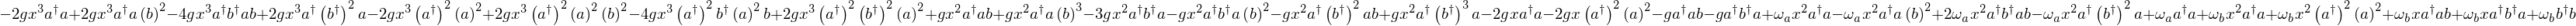

In [ ]:
H2 = hamiltonian_transformation(U, H1, independent=True, expansion_search=False, N=2)

H3 = normal_ordered_form(H2.expand(), independent=True)

H3

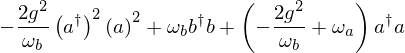

In [ ]:
H4 = H3.subs({x**2: 0, x**3: 0, x: g/omega_b})  # neglect higher order terms

H4 = collect(H4, Dagger(a)*a)

H4

In this Hamiltonian, the mechanical and optical mode is effectively decoupled, but the influence of the mechanical mode on the optical mode is described by the induced Kerr nonlinearity for the optical mode.

## Versions

In [ ]:
%reload_ext version_information

%version_information sympy, sympsi

Software versions
Python 3.4.1 (default, Sep 20 2014, 19:44:17) [GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
IPython 2.3.0
OS Darwin 13.4.0 x86_64 i386 64bit
sympy 0.7.5-git
sympsi 0.1.0.dev-0c6e514
Thu Oct 09 16:16:53 2014 JST

# Lecture 7 - Symbolic quantum mechanics using SymPsi - Semiclassical equations of motion

## Setup modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
from sympy import *
init_printing()

In [ ]:
from sympsi import *
from sympsi.boson import *
from sympsi.pauli import *
from sympsi.operatorordering import *
from sympsi.expectation import *
from sympsi.operator import OperatorFunction

## Semiclassical equations of motion

The dynamics of an open quantum system with a given Hamiltonian, $H$, and some interaction with an environment that acts on the system through the sytem operator $a$, and with rate $\kappa$, can often be described with a Lindblad master equation for the dynamics of the system density matrix $\rho$:

$$
\frac{d}{dt}\rho = -i[H, \rho] + \kappa \mathcal{D}[a]\rho,
$$

where the Lindblad superoperator $\mathcal{D}$ is

$$
\mathcal{D}[a]\rho = a \rho a^\dagger -\frac{1}{2}\rho a^\dagger a - \frac{1}{2}a^\dagger a \rho.
$$

One common approach to solve for the dynamics of this system is to represent the system operators and the density operator as matrices, possibly in a truncated state space, and solve the matrix-valued ODE problem numerically.

Another approach is to use the adjoint master equation for the system operators $X$:

$$
\frac{d}{dt} X =  i [H, X] + \kappa \mathcal{D}[a^\dagger]X
$$

and then solve for dynamics of the expectation values of the relevant system operators. The advantage of this method is that the ODEs are no longer matrix-valued, unlike the ODE for the density matrix. However, from the density matrix we can calculate any same-time expectation values, but with explicit ODEs for expectation values we need to select in advance which operator's expectation values we want to generate equations for. 

We can easily generate an equation for the expectation value of a specific operator by multiplying the master equation for $\rho$ from the left with an operator $X$, and then take the trace over the entire equation. Doing this we obtain:

$$
X\frac{d}{dt}\rho = -iX[H, \rho] + \kappa X\mathcal{D}[a]\rho
$$

and taking the trace:

$$
{\rm Tr}\left(X\frac{d}{dt}\rho\right) = -i{\rm Tr}\left(X[H, \rho]\right) + \kappa {\rm Tr}\left(X\mathcal{D}[a]\rho\right)
$$

using the cyclic permutation properties of traces:

$$
\frac{d}{dt}{\rm Tr}\left(X\rho\right) = -i{\rm Tr}\left([X, H]\rho\right) + \kappa {\rm Tr}\left((\mathcal{D}[a]X) \rho\right)
$$

we end up with an equation for the expectation value of the operator $X$:

$$
\frac{d}{dt}\langle X\rangle 
= 
i\langle [H, X] \rangle + \kappa \langle \mathcal{D}[a]X \rangle
$$

Note that this is a C-number equation, and therefore not as complicated to solve as the master equation for the density matrix. However, the problem with this C-number equation is that the expressions $[H, X]$
 and $\mathcal{D}[a]X$ in general will introduce dependencies on other system operators, so we obtain a system of coupled C-number equations. If this system of equations closes when a finite number of operators are included, then we can use this method to solve the dynamics of these expectation values exactly. If the system of equations do not close, which is often the case for coupled systems, then we can still use this method if we introduce some rule for truncating high-order operator expectation values (for example, by discarding high-order terms or by factoring them in expectation values of lower order). However, in this case the results are no longer exact, and is called a semi-classical equation of motion.

With SymPsi we can automatically generate semiclassical equations of motion for operators in a system described by a given Hamiltonian and a set of collapse operators that describe its coupling to an environment.

## Driven harmonic oscillator

Consider a driven harmonic oscillator, which interaction with an bath at some temperature that corresponds to $N_{\rm th}$ average photons. We begin by setting up symbolic variables for the problem parameters and the system operators in SymPsi: 

In [ ]:
w, t, Nth, Ad, kappa = symbols(r"\omega, t, n_{th}, A_d, kappa", positive=True)

In [ ]:
a = BosonOp("a")
rho = Operator(r"\rho")
rho_t = OperatorFunction(rho, t)

In [ ]:
H = w * Dagger(a) * a + Ad * (a + Dagger(a))

Eq(Symbol("H"), H)

The master equation for this system can be generated using the `master_equation` function:

In [ ]:
c_ops = [sqrt(kappa * (Nth + 1)) * a, sqrt(kappa * Nth) * Dagger(a)]

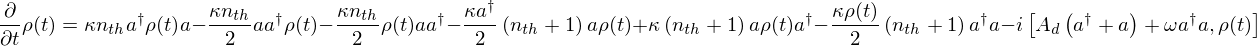

In [ ]:
me = master_equation(rho_t, t, H, c_ops)

me

Equation for the system operators can be generated using the function `operator_master_equation`, and for the specific case of the cavity operator $a$ we obtain:

In [ ]:
# first setup time-dependent operators
a_t = OperatorFunction(a, t)
a_to_a_t = {a: a_t, Dagger(a): Dagger(a_t)}
H_t = H.subs(a_to_a_t)
c_ops_t = [c.subs(a_to_a_t) for c in c_ops]

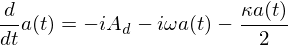

In [ ]:
# operator master equation for a
ome_a = operator_master_equation(a_t, t, H_t, c_ops_t)

Eq(ome_a.lhs, normal_ordered_form(ome_a.rhs.doit().expand()))

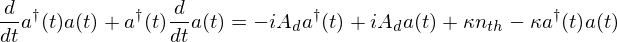

In [ ]:
# operator master equation for n = Dagger(a) * a
ome_n = operator_master_equation(Dagger(a_t) * a_t, t, H_t, c_ops_t)

Eq(ome_n.lhs, normal_ordered_form(ome_n.rhs.doit().expand()))

From these operator equations we see that the equation for $a$ depends only on the operator $a$, while the equation for $n$ depends on $n$, $a$, $a^\dagger$. So to solve the latter equation we therefore also have to generate an equation for $a^\dagger$.

### System of semiclassical equations

In [ ]:
ops, op_eqm, sc_eqm, sc_ode, ofm, oim = semi_classical_eqm(H, c_ops)

In [ ]:
html_table([[Eq(Expectation(key), ofm[key]), sc_ode[key]] for key in operator_sort_by_order(sc_ode)])

$\left\langle {{a}^\dagger} \right\rangle = \operatorname{A_{0}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{0}}{\left (t \right )} = i A_{d} + i \omega \operatorname{A_{0}}{\left (t \right )} - \frac{\kappa}{2} \operatorname{A_{0}}{\left (t \right )}$
$\left\langle {a} \right\rangle = \operatorname{A_{1}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{1}}{\left (t \right )} = - i A_{d} - i \omega \operatorname{A_{1}}{\left (t \right )} - \frac{\kappa}{2} \operatorname{A_{1}}{\left (t \right )}$
$\left\langle {{a}^\dagger} {a} \right\rangle = \operatorname{A_{2}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{2}}{\left (t \right )} = - i A_{d} \operatorname{A_{0}}{\left (t \right )} + i A_{d} \operatorname{A_{1}}{\left (t \right )} + \kappa n_{{th}} - \kappa \operatorname{A_{2}}{\left (t \right )}$


Since this is a system of linear ODEs, we can write it on matrix form:

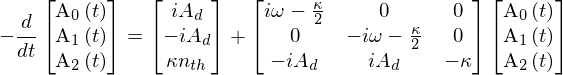

In [ ]:
A_eq, A, M, b = semi_classical_eqm_matrix_form(sc_ode, t, ofm)

A_eq

### Steadystate

We can solve for the steadystate by setting the left-hand-side of the ODE to zero, and solve the linear system of equations:

In [ ]:
A_sol = M.LUsolve(-b)

The solution for the three system operators are:

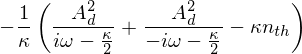

In [ ]:
A_sol[ops.index(Dagger(a)*a)]

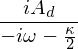

In [ ]:
A_sol[ops.index(a)]

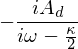

In [ ]:
A_sol[ops.index(Dagger(a))]

We can also solve for the steadystate directly from the ODE by settings its right-hand-side to zero, and using the SymPy `solve` function: 

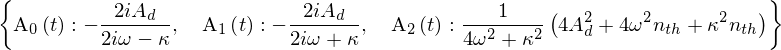

In [ ]:
solve([eq.rhs for eq in sc_ode.values()], list(ofm.values()))

### Solve in the ODEs

For systems with a small number of dependent operators we can solve the resulting system of ODEs directly:

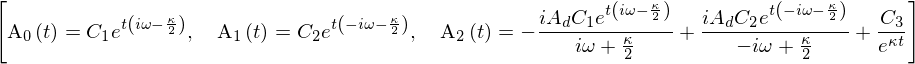

In [ ]:
sols = dsolve(list(sc_ode.values())); sols

In [ ]:
# hack
tt = [s for s in sols[0].rhs.free_symbols if s.name == 't'][0]

We also need o specify the initial conditions: Here the initial conditions are $\langle a(0) \rangle = \langle a^\dagger(0) \rangle = 2$ and $\langle a^\dagger(0)a(0) \rangle = 4$.

In [ ]:
ics = {ofm[Dagger(a)].subs(tt, 0): 2, 
       ofm[a].subs(tt, 0): 2,
       ofm[Dagger(a)*a].subs(tt, 0): 4}; ics

In [ ]:
constants = set(sum([[s for s in sol.free_symbols if (str(s)[0] == 'C')] for sol in sols], [])); constants

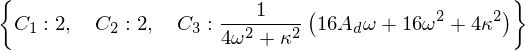

In [ ]:
C_sols = solve([sol.subs(tt, 0).subs(ics) for sol in sols], constants); C_sols

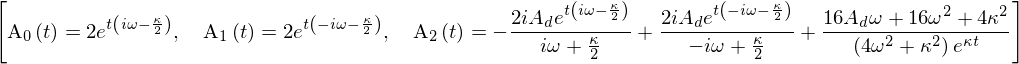

In [ ]:
sols_with_ics = [sol.subs(C_sols) for sol in sols]; sols_with_ics

Now let's insert numerical values for the system parameters so we can plot the solution:

In [ ]:
values = {w: 1.0, Ad: 0.0, kappa: 0.1, Nth: 0.0}

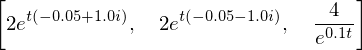

In [ ]:
sols_funcs = [sol.rhs.subs(values) for sol in sols_with_ics]; sols_funcs

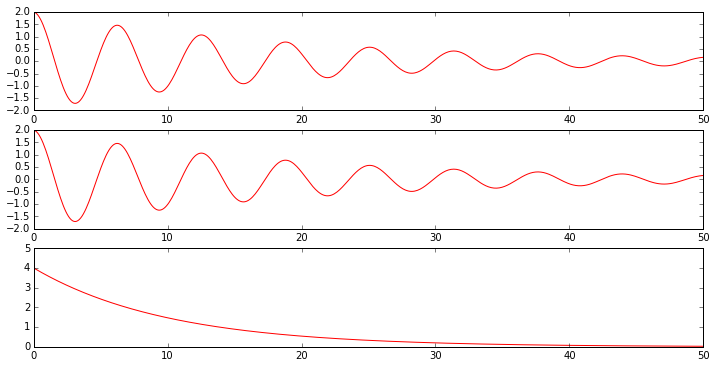

In [ ]:
times = np.linspace(0, 50, 500)

y_funcs = [lambdify([tt], sol_func, 'numpy') for sol_func in sols_funcs]

fig, axes = plt.subplots(len(y_funcs), 1, figsize=(12, 6))

for n, y_func in enumerate(y_funcs):
    axes[n].plot(times, np.real(y_func(times)), 'r')
    
axes[2].set_ylim(0, 5);

## Driven dissipative two-level system

In [ ]:
sx, sy, sz, sm, sp = SigmaX(), SigmaY(), SigmaZ(), SigmaMinus(), SigmaPlus()

In [ ]:
Omega, gamma_0, N, t = symbols("\Omega, \gamma_0, N, t", positive=True)

values = {Omega: 1.0, gamma_0: 0.5, N: 1.75}

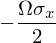

In [ ]:
H = -Omega/2 * sx
H

In [ ]:
c_ops = [sqrt(gamma_0 * (N + 1)) * pauli_represent_x_y(sm), 
         sqrt(gamma_0 * N) * pauli_represent_x_y(sp)]

In [ ]:
ops, op_eqm, sc_eqm, sc_ode, ofm, oim = semi_classical_eqm(H, c_ops)

In [ ]:
html_table([[Eq(Expectation(key), ofm[key]), sc_ode[key]] for key in operator_sort_by_order(sc_ode)])

$\left\langle {\sigma_x} \right\rangle = \operatorname{A_{0}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{0}}{\left (t \right )} = - N \gamma_{0} \operatorname{A_{0}}{\left (t \right )} - \frac{\gamma_{0}}{2} \operatorname{A_{0}}{\left (t \right )}$
$\left\langle {\sigma_y} \right\rangle = \operatorname{A_{1}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{1}}{\left (t \right )} = - N \gamma_{0} \operatorname{A_{1}}{\left (t \right )} + \Omega \operatorname{A_{2}}{\left (t \right )} - \frac{\gamma_{0}}{2} \operatorname{A_{1}}{\left (t \right )}$
$\left\langle {\sigma_z} \right\rangle = \operatorname{A_{2}}{\left (t \right )}$,$\frac{d}{d t} \operatorname{A_{2}}{\left (t \right )} = - 2 N \gamma_{0} \operatorname{A_{2}}{\left (t \right )} - \Omega \operatorname{A_{1}}{\left (t \right )} - \gamma_{0} \operatorname{A_{2}}{\left (t \right )} - \gamma_{0}$


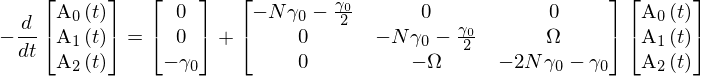

In [ ]:
A_eq, A, M, b = semi_classical_eqm_matrix_form(sc_ode, t, ofm)

A_eq

### Steadystate

In [ ]:
A_sol = M.LUsolve(-b)

The steadystate expectation value of $\sigma_x$:

In [ ]:
A_sol[ops.index(sx)]

The steadystate expectation value of $\sigma_y$:

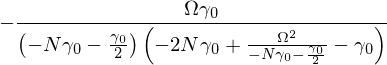

In [ ]:
A_sol[ops.index(sy)]

The steadystate expectation value of $\sigma_z$:

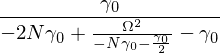

In [ ]:
A_sol[ops.index(sz)]

Steadystate of $\sigma_+$:

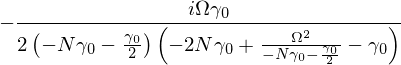

In [ ]:
pauli_represent_x_y(sp).subs({sx: A_sol[ops.index(sx)], sy: A_sol[ops.index(sy)]})

Steadystate of $\sigma_-$:

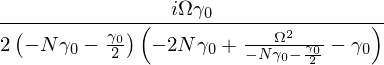

In [ ]:
pauli_represent_x_y(sm).subs({sx: A_sol[ops.index(sx)], sy: A_sol[ops.index(sy)]})

Alternatively we can also use the SymPy `solve` function to find the steadystate solutions:

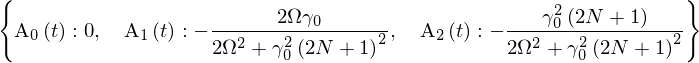

In [ ]:
solve([eq.rhs for eq in sc_ode.values()], list(ofm.values()))

At zero temperature:

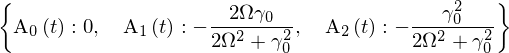

In [ ]:
solve([eq.subs(N, 0).rhs for eq in sc_ode.values()], list(ofm.values()))

## Versions

In [ ]:
%reload_ext version_information

%version_information sympy, sympsi

Software versions
Python 3.4.1 (default, Sep 20 2014, 19:44:17) [GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
IPython 2.3.0
OS Darwin 13.4.0 x86_64 i386 64bit
sympy 0.7.5-git
sympsi 0.1.0.dev-0c6e514
Sun Oct 12 21:42:08 2014 JST